Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, $\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})}{p(x|\hat{\mu}, \hat{\alpha})}$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x|\hat{\mu}, \hat{\alpha})/p_{ref}(x)}$$

to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Factorizing out the $\alpha$-dependence in the density ratios:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Furthermore, instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem to training only parameter-independent density ratios.

Let's set this up for the ttbar dataset!

In [2]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-12 01:41:39.639992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 01:41:40.421463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
weights = np.load(f"{saved_data}weights.npy")

In [4]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, and only perform the NSBI fit in this selected analysis region. A natural choice for the reference hypothesis is then a mix of signal hypotheses $p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx}$.

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \frac{\sum_S P_S (x)}{\sum_B P_B(x)} $$

where $P_X$ are the probability scores outputted from the softmax layer of the trained NN.



Training the Preselection NN
===

In [5]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

In [6]:
# Split data into training and validation sets (including weights)
X_train, X_val, y_train, y_val, weight_train, weight_val = train_test_split(
    training_features, train_labels, weights_normed, test_size=0.15, random_state=42,
          stratify=train_labels)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit & transform training data
X_val = scaler.transform(X_val)

# Define the neural network model
model = keras.Sequential([
    layers.Input(shape=(training_features.shape[1],)),  # Input layer
    layers.Dense(100, activation='swish'),
    layers.Dense(100, activation='swish'),
    layers.Dense(100, activation='swish'),
    layers.Dense(3, activation='softmax')  # Output layer for 5 classes
])

# Compile the model
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              weighted_metrics=["accuracy"])

# Train the model with sample weights
model.fit(X_train, y_train, sample_weight=weight_train, 
          validation_data=(X_val, y_val, weight_val), epochs=20, batch_size=1024)


Epoch 1/20


2025-02-12 01:43:19.651478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:81:00.0, compute capability: 8.0
2025-02-12 01:43:20.618185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-12 01:43:20.664084: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f51c8f1e340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-12 01:43:20.664137: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-02-12 01:43:20.670628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025

2935/2935 [==============================] - 8s 2ms/step - loss: 6.9504e-07 - accuracy: 0.6415 - val_loss: 5.5983e-07 - val_accuracy: 0.7134
Epoch 2/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.4918e-07 - accuracy: 0.7179 - val_loss: 5.4233e-07 - val_accuracy: 0.7218
Epoch 3/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.4127e-07 - accuracy: 0.7209 - val_loss: 5.3809e-07 - val_accuracy: 0.7233
Epoch 4/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.3834e-07 - accuracy: 0.7216 - val_loss: 5.3598e-07 - val_accuracy: 0.7236
Epoch 5/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.3687e-07 - accuracy: 0.7222 - val_loss: 5.3484e-07 - val_accuracy: 0.7238
Epoch 6/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.3602e-07 - accuracy: 0.7224 - val_loss: 5.3419e-07 - val_accuracy: 0.7239
Epoch 7/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.3549e-07 - accuracy: 

In [7]:
features_scaled = scaler.transform(training_features)

In [8]:
# Get predictions (softmax outputs)
pred_NN = model.predict(features_scaled)

110475/110475 [==============================] - 66s 598us/step


(3535175,)


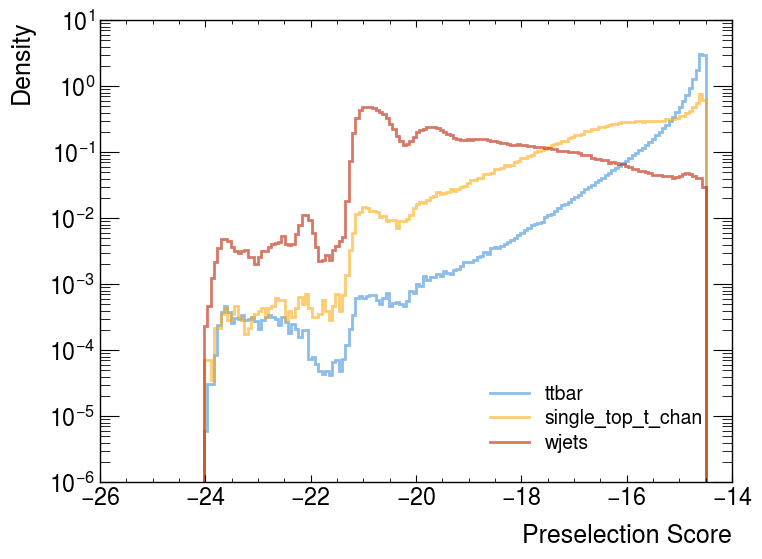

In [9]:

presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(np.sum([pred_NN[:, labels_dict[key]] for key in list(labels_dict.keys())[1:]])))

print(presel_score.shape)
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}
for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [10]:
np.save(f'{saved_data}presel_score.npy', presel_score)

Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

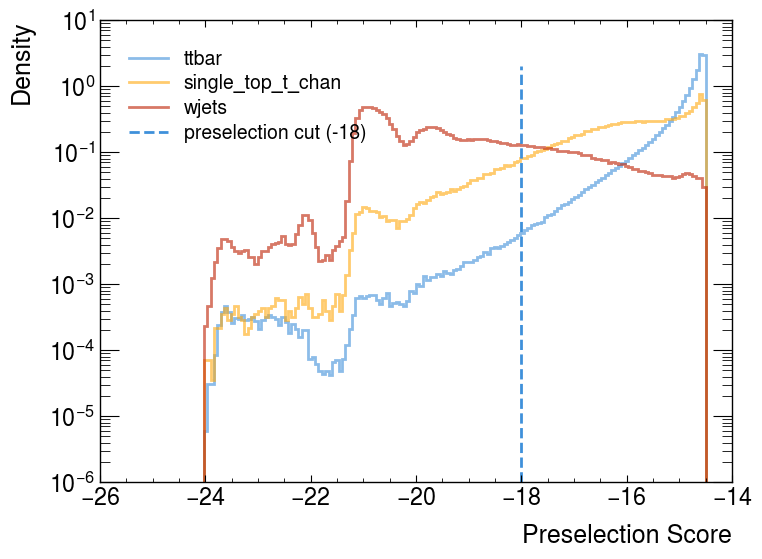

In [12]:
preselection_cut = -18 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [13]:
# Make the preselections

training_features = training_features[presel_score>=preselection_cut].copy()
train_labels = train_labels[presel_score>=preselection_cut].copy()
weights = weights[presel_score>=preselection_cut].copy()

preselection_score_selected = presel_score[presel_score>=preselection_cut].copy()


In [14]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [15]:
# Build a pandas dataframe from the arrays for density ratio training and validation
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']
dataset = pd.DataFrame(training_features, columns=columns)

dataset['log_lepton_pt'] = np.log(dataset['lepton_pt'].ravel())
dataset['log_H_T'] = np.log(dataset['H_T'].ravel()+1.0)

dataset['presel_score'] = preselection_score_selected
dataset['train_labels'] = train_labels
dataset['type'] = type_vec
dataset['weights'] = weights

In [16]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset['weights_normed'] = weights_normed


In [17]:
# Save the preselected dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='w')


In [18]:
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['lepton_pt', 'lepton_eta', 'lepton_phi']

columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']

columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Since we chose $p_{t\bar{t}}$ as the reference hypothesis, this leaves us with the estimation of:

$$\frac{p_\text{single top}}{p_{t\bar{t}}}(x) \, , \frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$$

In [19]:
# Choose ttbar as the reference hypothesis
dataset_ch_wjets_ref = pd.concat([dataset[dataset['type']=='wjets'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_wjets_ref['train_labels'] = 0
dataset_ch_wjets_ref.loc[dataset_ch_wjets_ref['type']=='ttbar', 'train_labels'] = 1


In [20]:
NN_training_channels_dict = {}


In [52]:

rnd_seed_traintestsplit = 42
channel_names = ['wjets', 'ttbar']

# Save paths
output_dir = './output_general_wjets/'
output_name = 'first_training_wjets'
path_to_ratios = './output_ratios_wjets/'
path_to_figures = './output_figures_wjets/'
path_to_models = './output_model_params_wjets/'

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['wjets'] = TrainEvaluate_NN(dataset_ch_wjets_ref, 
                                                       dataset_ch_wjets_ref['weights_normed'],
                                                       dataset_ch_wjets_ref['train_labels'],
                                                       columns, 
                                                       columns_scaling, rnd_seed_traintestsplit, 
                                                       channel_names, output_dir, output_name, 
                                                        path_to_figures=path_to_figures,
                                                        path_to_ratios=path_to_ratios, 
                                                        path_to_models=path_to_models)



Sum of weights of class 0: 0.7999985169695758
Sum of weights of class 1: 0.7999952509534914
Using swish activation function
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1000)              5000      
                                                                 
 dense_11 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_12 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_13 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 3009001 (11.48 MB)
Trainable params: 3009001 (11

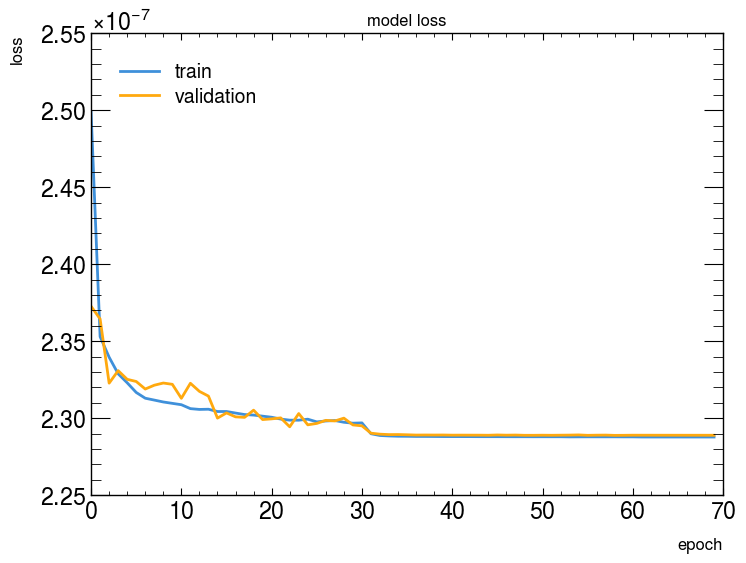

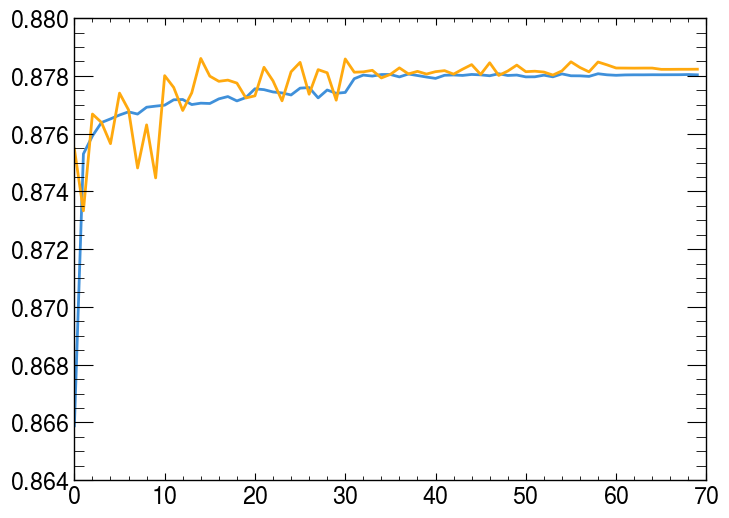

843/843 - 1s - 566ms/epoch - 671us/step
15924/15924 - 9s - 9s/epoch - 586us/step
3372/3372 - 2s - 2s/epoch - 614us/step
63696/63696 - 38s - 38s/epoch - 599us/step
ttbar training data prediction (max) = 0.98328686
ttbar training data prediction (min) = 0.00087619
wjets training data prediction (max) = 0.9841599
wjets training data prediction (min) = 0.0035235037
ttbar training data prediction (max) = 0.9833017
ttbar training data prediction (min) = 0.0009128507
wjets training data prediction (max) = 0.98413587
wjets training data prediction (min) = 0.009360705


<Figure size 800x600 with 0 Axes>

In [53]:
# Train the density ratio NN
NN_training_channels_dict['wjets'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


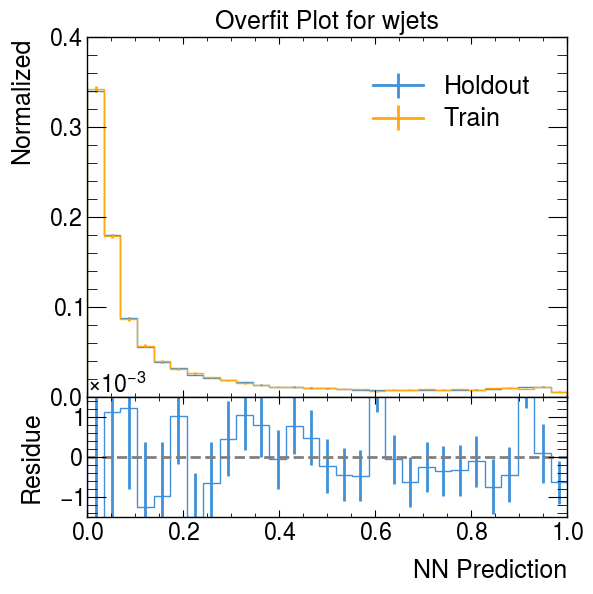

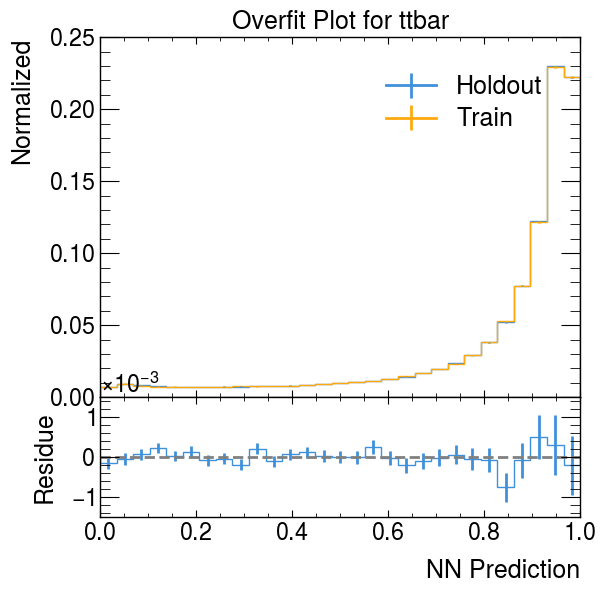

<Figure size 800x600 with 0 Axes>

In [54]:
NN_training_channels_dict['wjets'].make_overfit_plots()

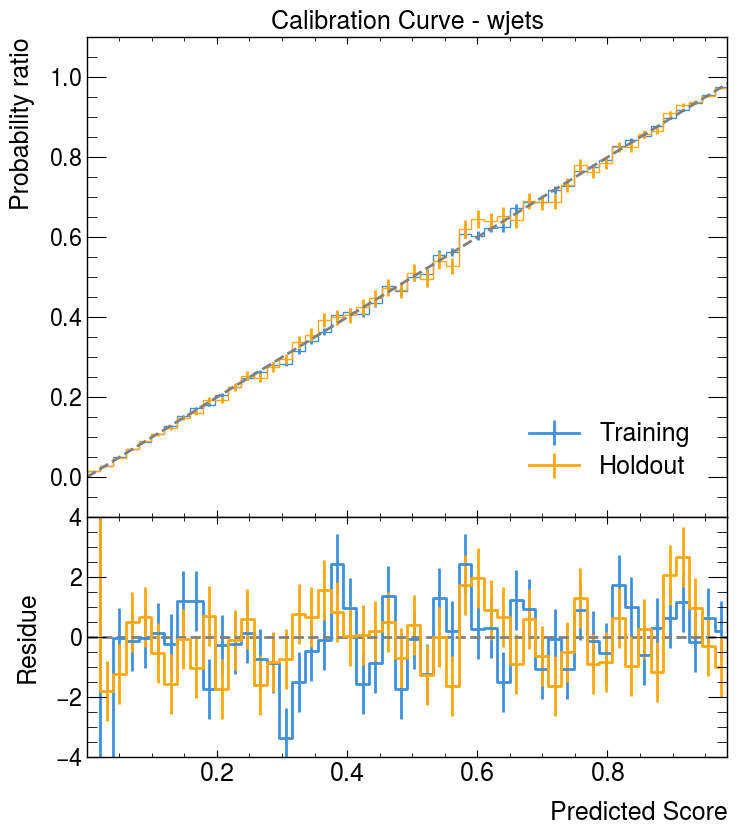

observable not recognized


<Figure size 800x600 with 0 Axes>

In [55]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='score')

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:156: RuntimeWarning: divide by zero encountered in log
  h_log = np.log(hist_num/hist_den)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:157: RuntimeWarning: invalid value encountered in divide
  h_log_err = np.sqrt((hist_num_err/hist_num**2)+(hist_den_err/hist_den**2))
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: divide by zero encountered in log
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:163: RuntimeWarning: invalid value encountered in divide
  h_log_holdout_err = np.sqrt((hist_num_holdout_err/hist_num_holdout**2)+(hist_den_holdout_err/hist_den_holdout**2))


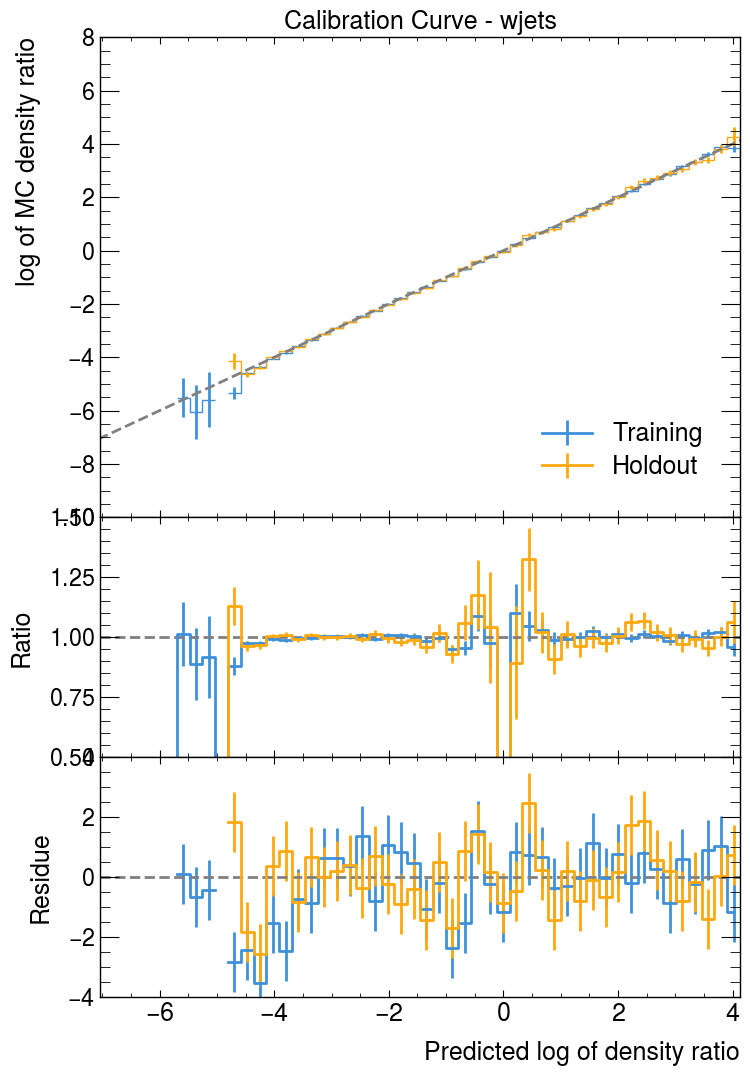

<Figure size 800x600 with 0 Axes>

In [56]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='llr')

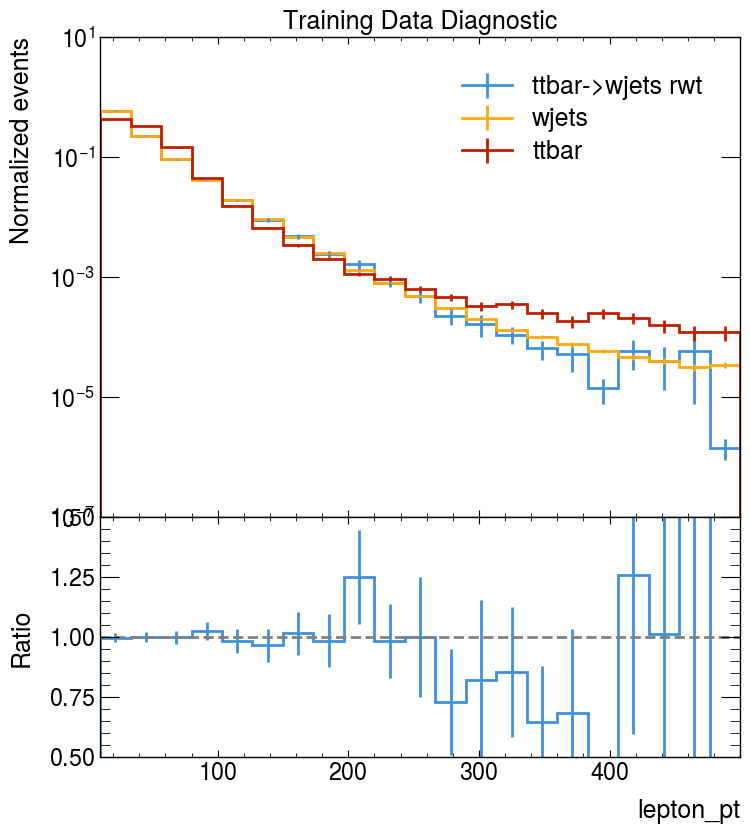

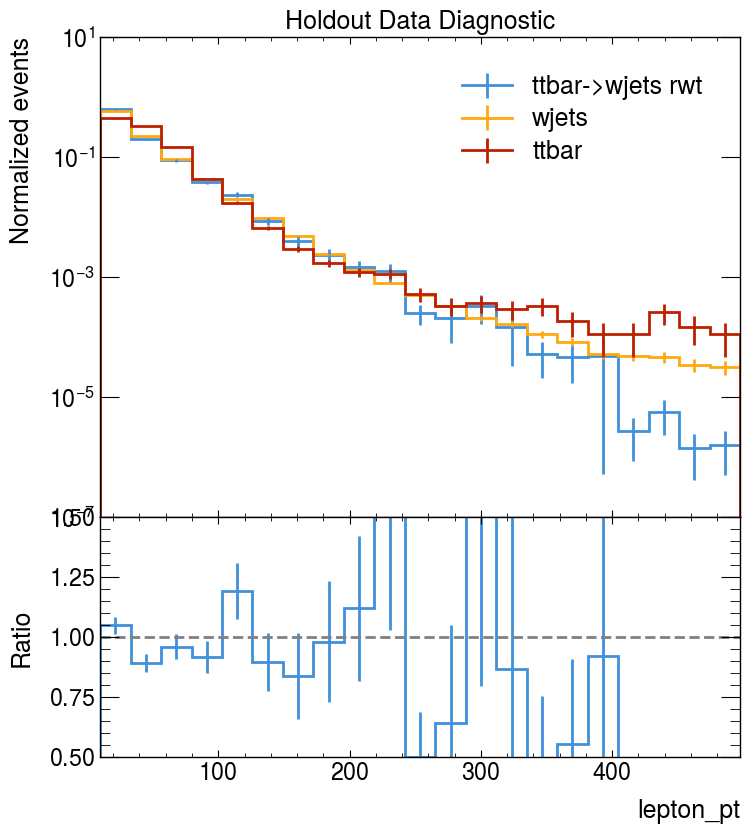

<Figure size 800x600 with 0 Axes>

In [57]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


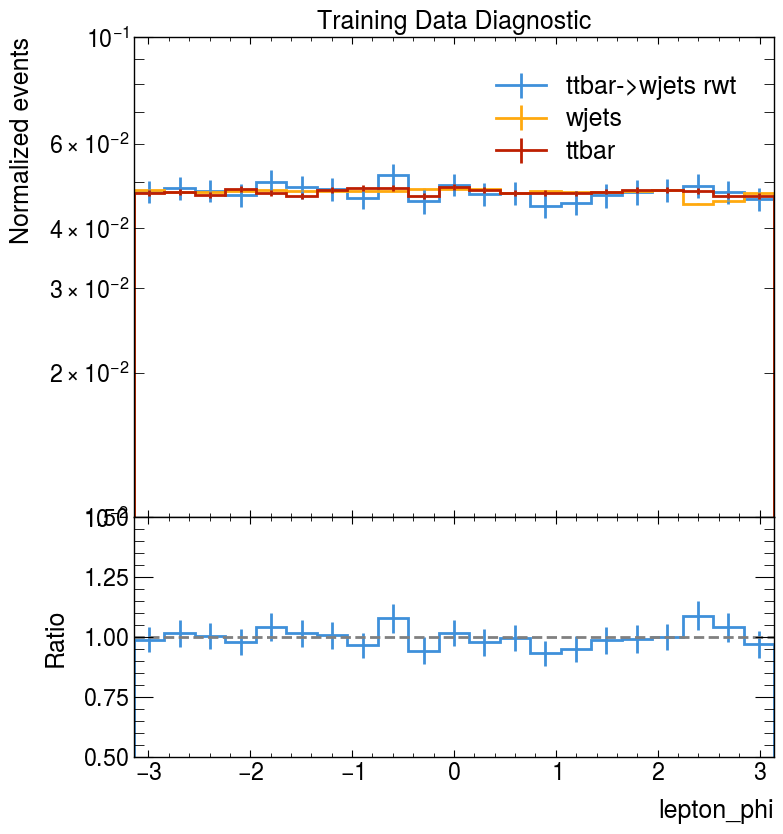

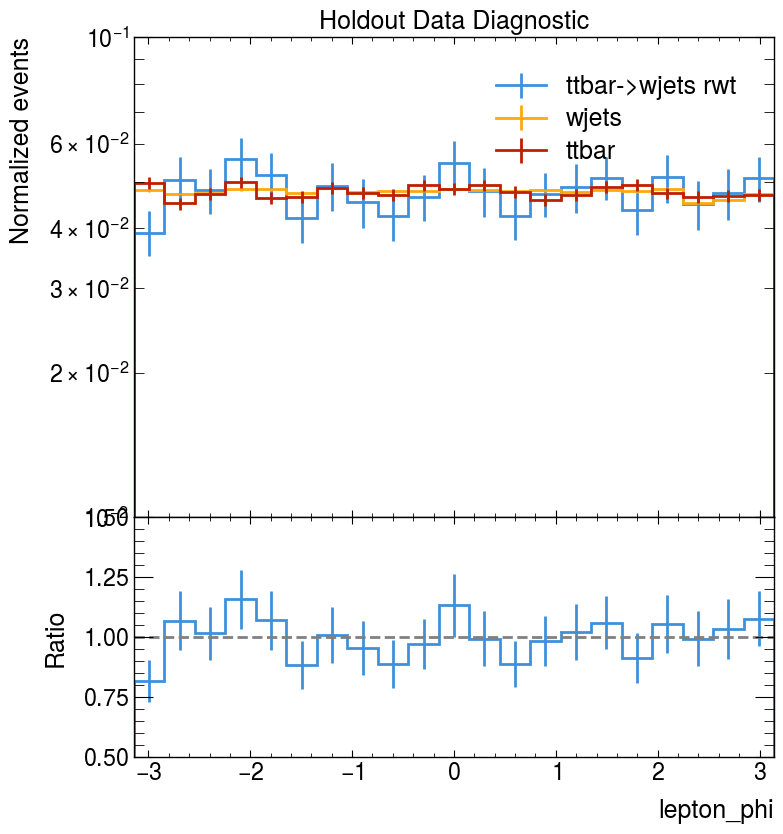

<Figure size 800x600 with 0 Axes>

In [58]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


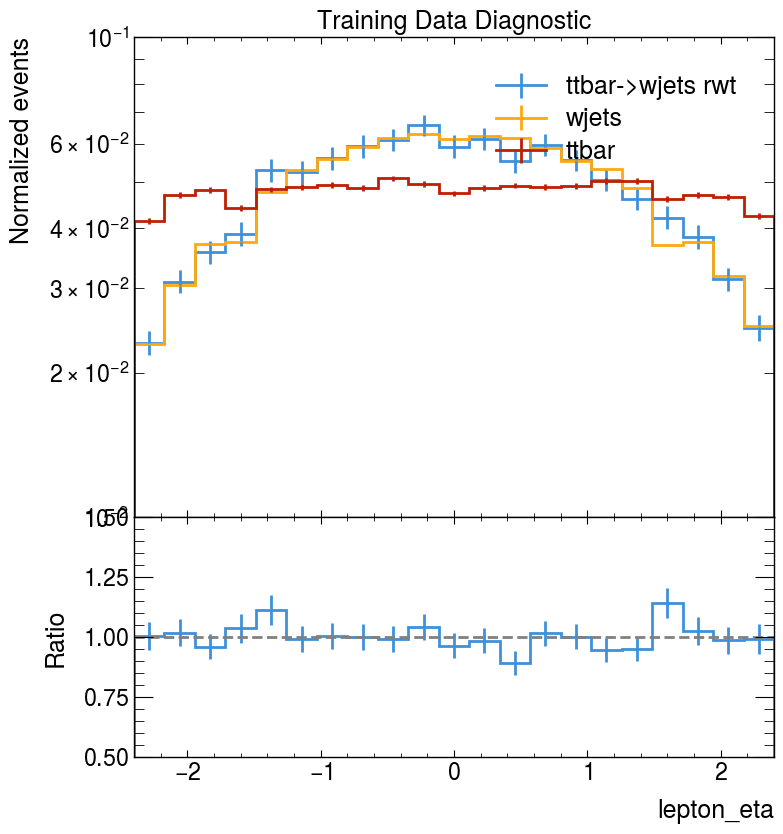

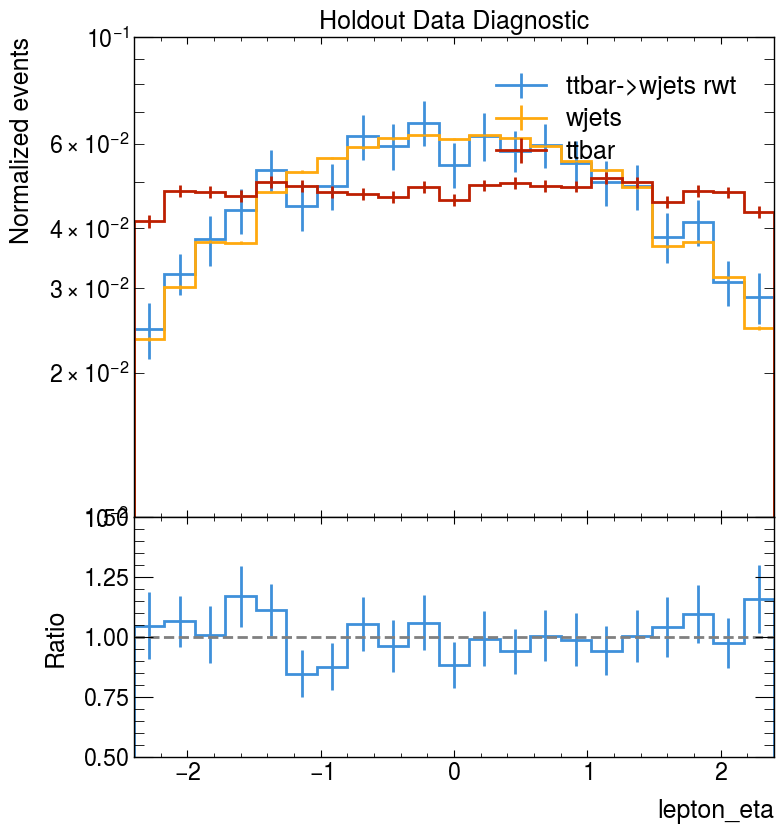

<Figure size 800x600 with 0 Axes>

In [59]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:281: RuntimeWarning: invalid value encountered in divide
  hep.histplot(rat, edges, yerr = np.abs(rat*np.sqrt((np.sqrt(hist_den_err)/hist_den)**2+(np.sqrt(hist_num_err)/hist_num)**2)), linewidth=2.0)


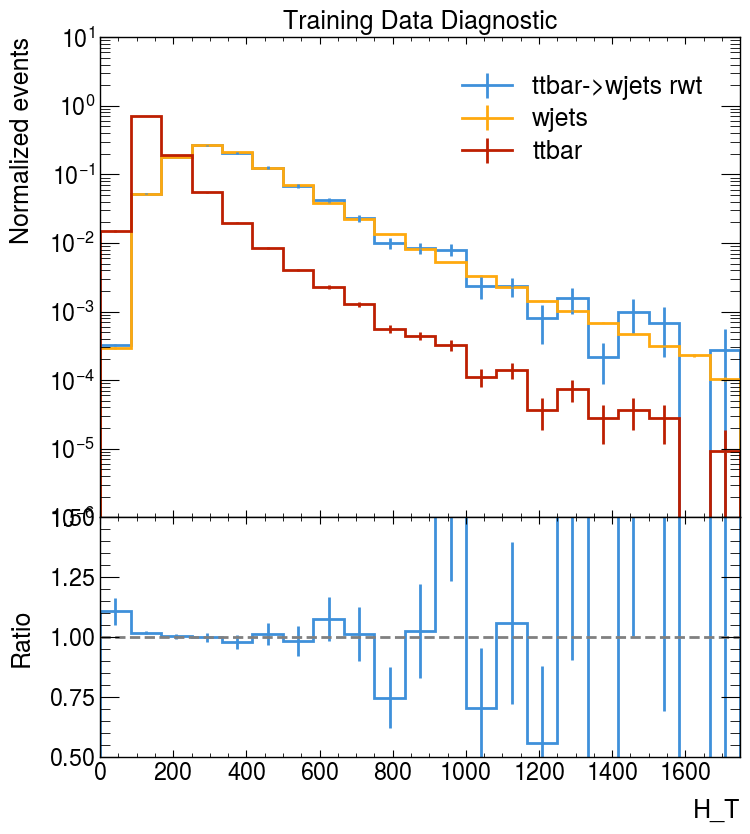

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:281: RuntimeWarning: invalid value encountered in divide
  hep.histplot(rat, edges, yerr = np.abs(rat*np.sqrt((np.sqrt(hist_den_err)/hist_den)**2+(np.sqrt(hist_num_err)/hist_num)**2)), linewidth=2.0)


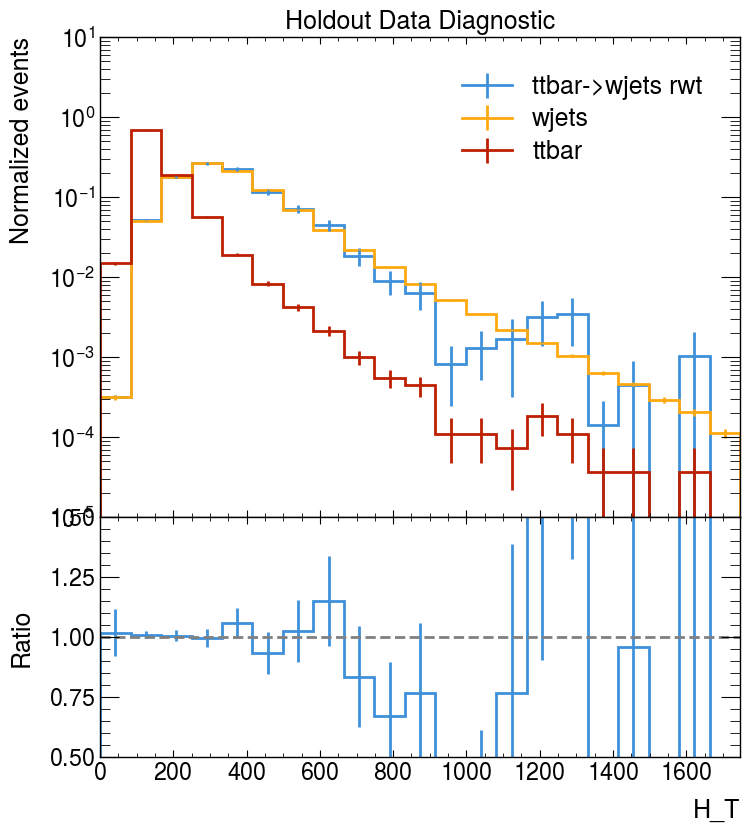

<Figure size 800x600 with 0 Axes>

In [60]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


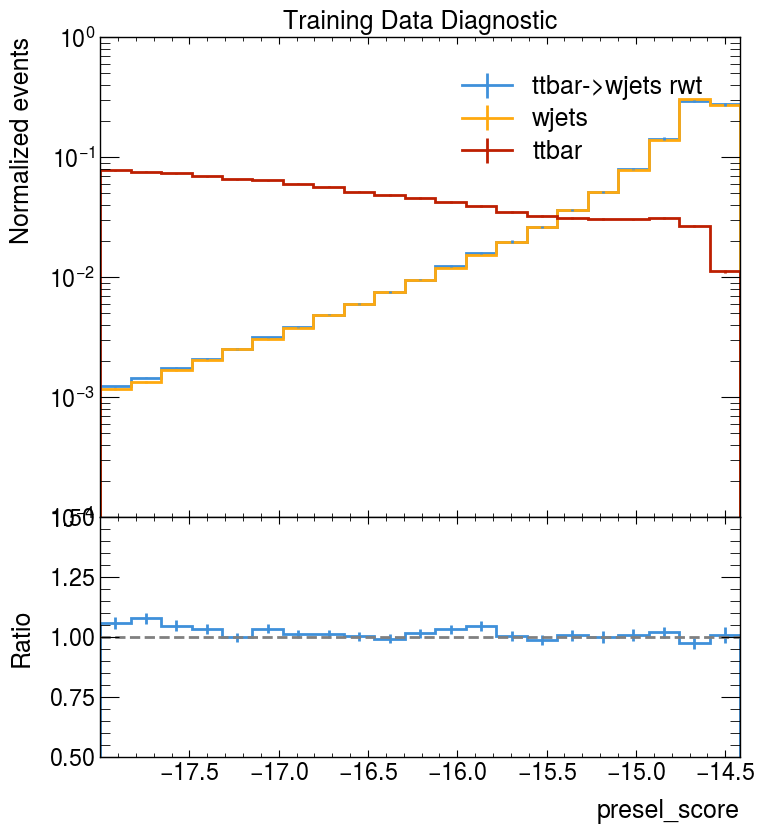

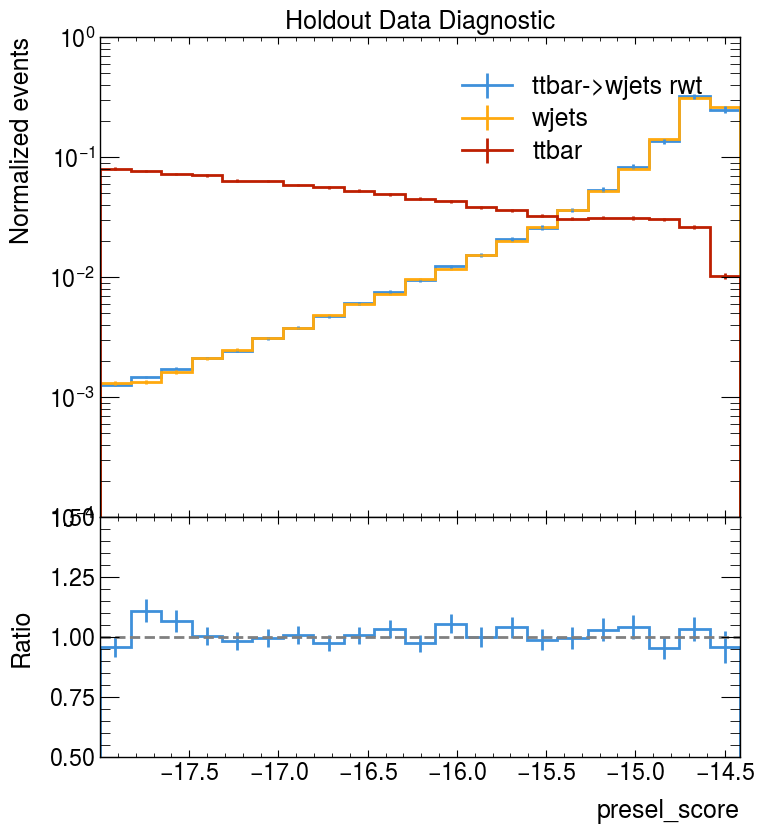

<Figure size 800x600 with 0 Axes>

In [61]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [62]:
NN_training_channels_dict['wjets'].evaluate_and_save_ratios(dataset)


96110/96110 - 59s - 59s/epoch - 610us/step


In [63]:
# Choose ttbar as the reference hypothesis
dataset_ch_single_top_t_chan_ref = pd.concat([dataset[dataset['type']=='single_top_t_chan'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_single_top_t_chan_ref['train_labels'] = 0
dataset_ch_single_top_t_chan_ref.loc[dataset_ch_single_top_t_chan_ref['type']=='ttbar', 'train_labels'] = 1


In [64]:

rnd_seed_traintestsplit = 42
channel_names = ['single_top_t_chan', 'ttbar']

# Save paths
output_dir = './output_general_singletop/'
output_name = 'first_training_singletop'
path_to_ratios = './output_ratios_singletop/'
path_to_figures = './output_figures_singletop/'
path_to_models = './output_model_params_singletop/'



importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['singletop'] = TrainEvaluate_NN(dataset_ch_single_top_t_chan_ref, 
                               dataset_ch_single_top_t_chan_ref['weights_normed'],
                               dataset_ch_single_top_t_chan_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



Sum of weights of class 0: 0.7999989817944849
Sum of weights of class 1: 0.8000031346585403
Using swish activation function
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1000)              5000      
                                                                 
 dense_16 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_17 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_18 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_19 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 3009001 (11.48 MB)
Trainable params: 3009001 (11

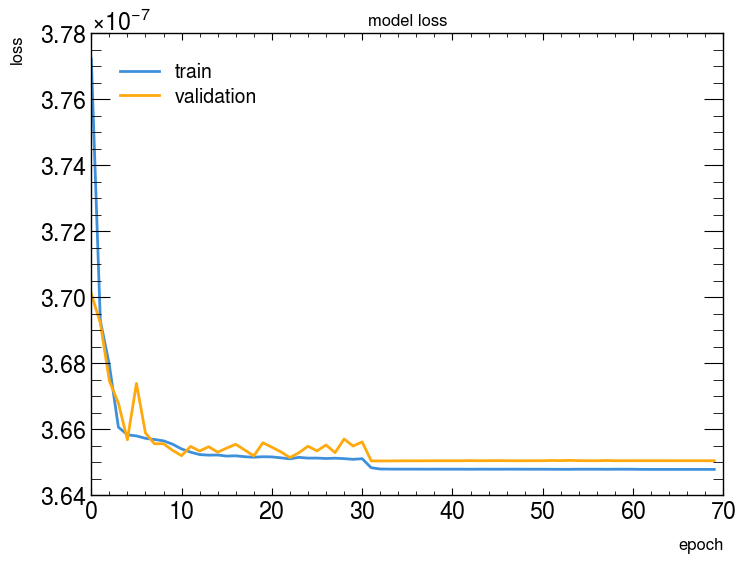

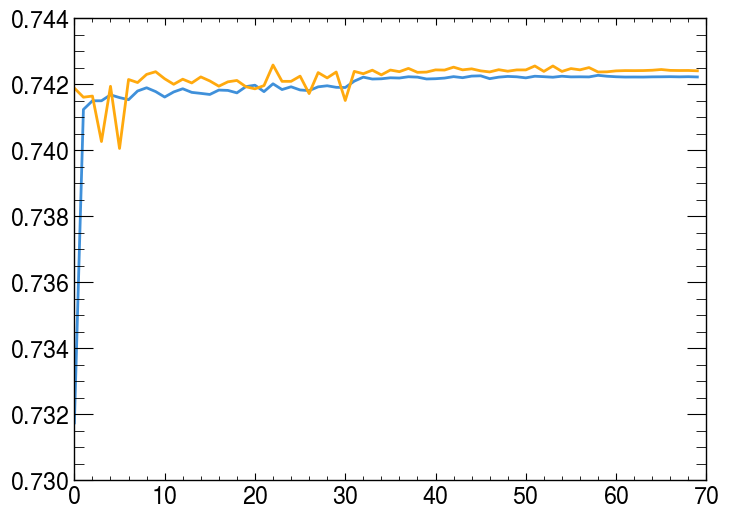

2456/2456 - 1s - 1s/epoch - 605us/step
15924/15924 - 9s - 9s/epoch - 594us/step
9822/9822 - 6s - 6s/epoch - 591us/step
63696/63696 - 38s - 38s/epoch - 594us/step
ttbar training data prediction (max) = 0.8500859
ttbar training data prediction (min) = 0.028435806
single_top_t_chan training data prediction (max) = 0.85258424
single_top_t_chan training data prediction (min) = 0.030481262
ttbar training data prediction (max) = 0.84891856
ttbar training data prediction (min) = 0.032627504
single_top_t_chan training data prediction (max) = 0.8525273
single_top_t_chan training data prediction (min) = 0.03683904


<Figure size 800x600 with 0 Axes>

In [65]:
# Train the density ratio NN
NN_training_channels_dict['singletop'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


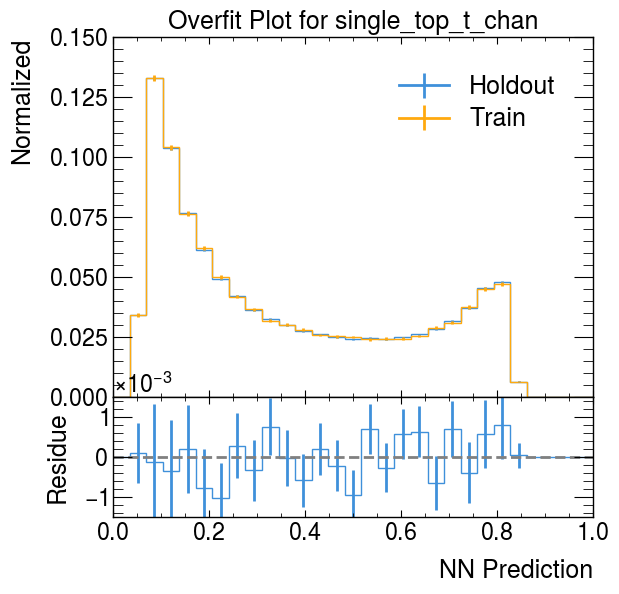

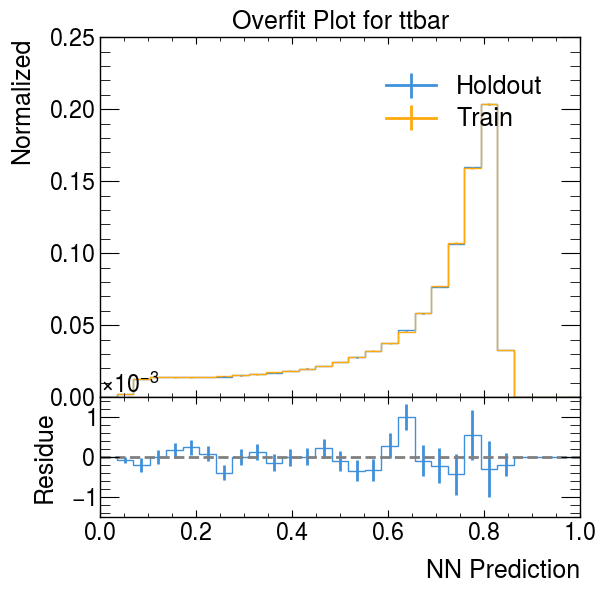

<Figure size 800x600 with 0 Axes>

In [66]:
NN_training_channels_dict['singletop'].make_overfit_plots()

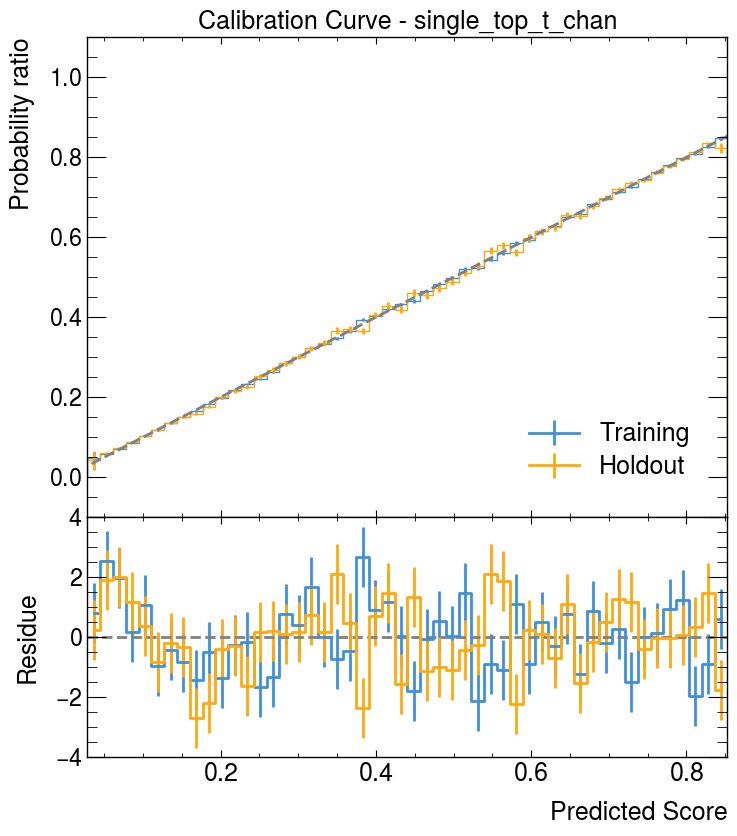

observable not recognized


<Figure size 800x600 with 0 Axes>

In [67]:
num_bins_cal = 50
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='score')

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: invalid value encountered in divide
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:162: RuntimeWarning: divide by zero encountered in log
  h_log_holdout = np.log(hist_num_holdout/hist_den_holdout)
/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:163: RuntimeWarning: invalid value encountered in divide
  h_log_holdout_err = np.sqrt((hist_num_holdout_err/hist_num_holdout**2)+(hist_den_holdout_err/hist_den_holdout**2))


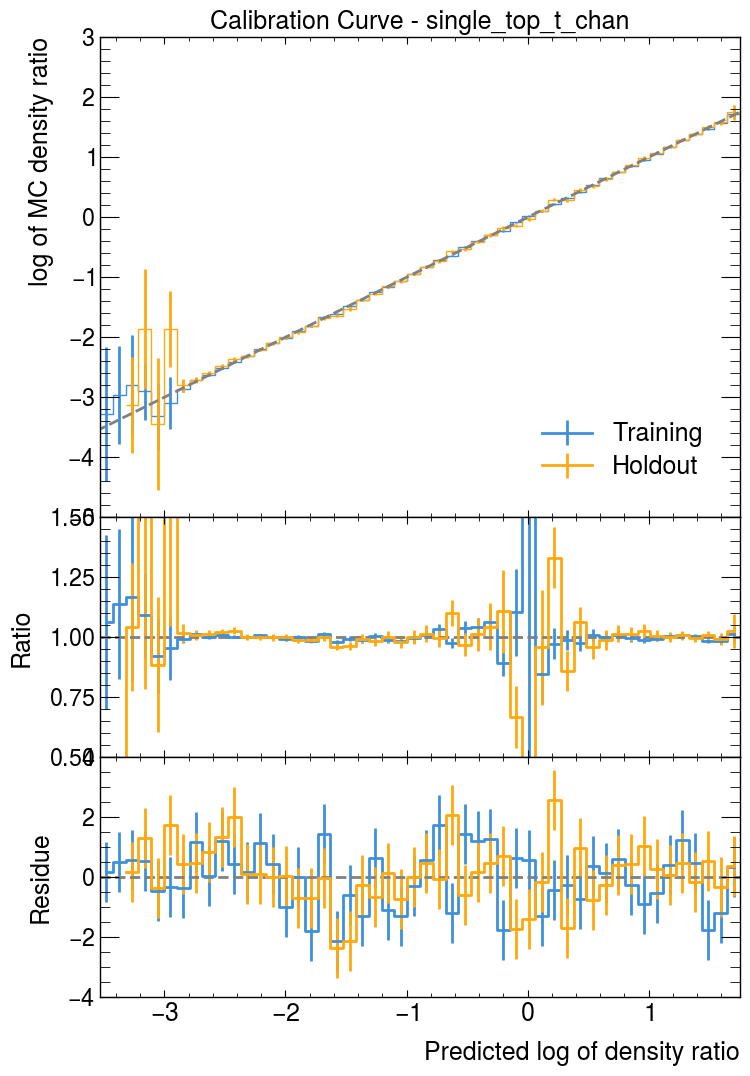

<Figure size 800x600 with 0 Axes>

In [68]:
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='llr')


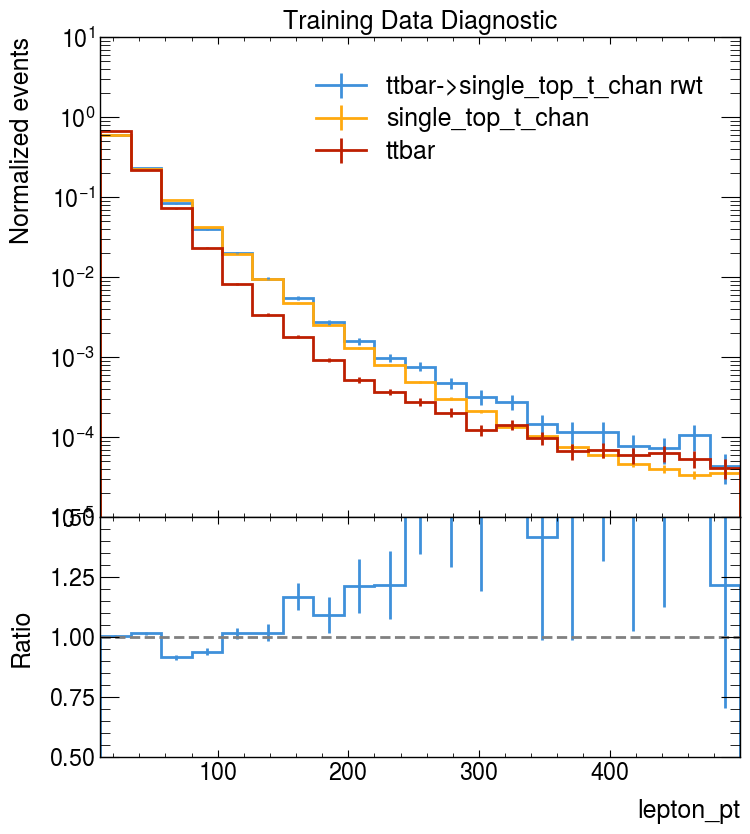

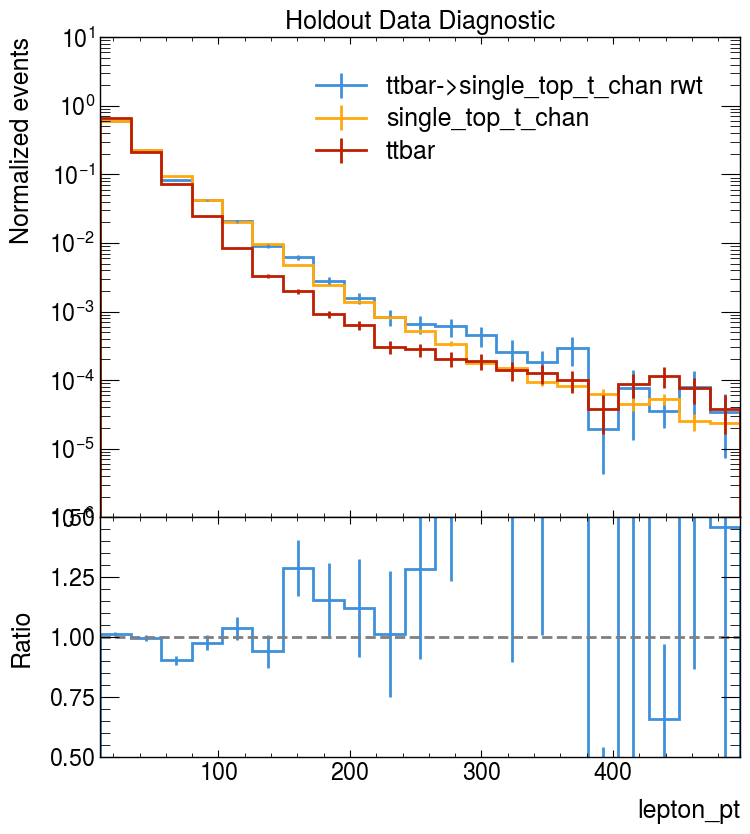

<Figure size 800x600 with 0 Axes>

In [69]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


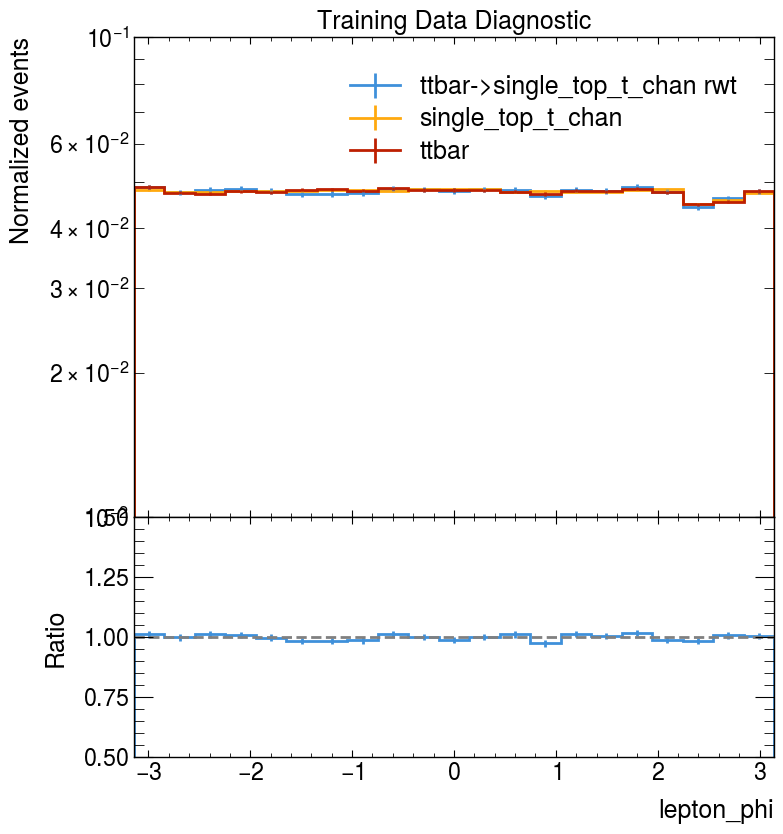

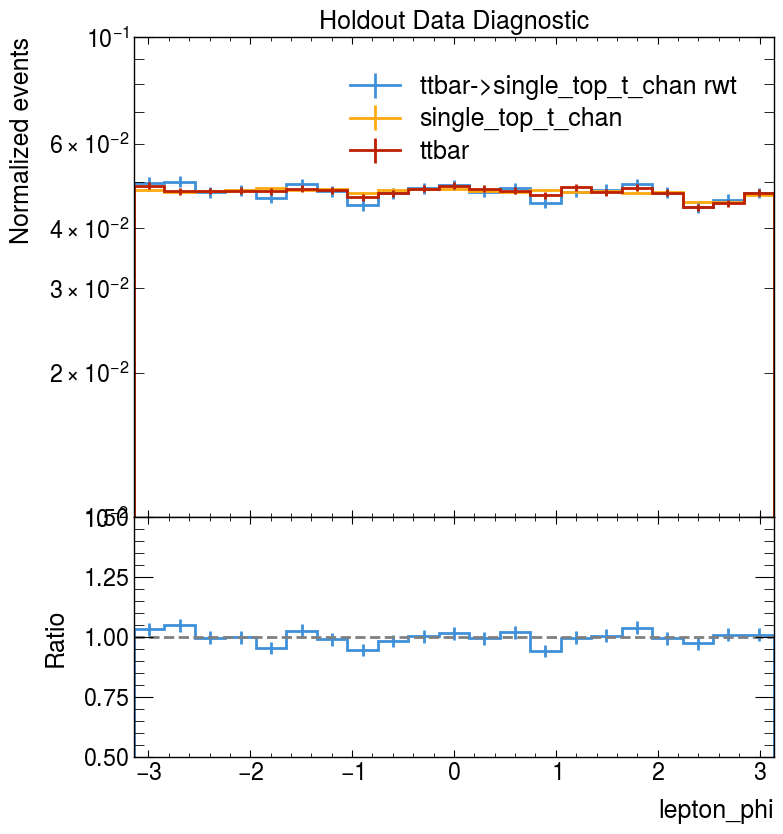

<Figure size 800x600 with 0 Axes>

In [70]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


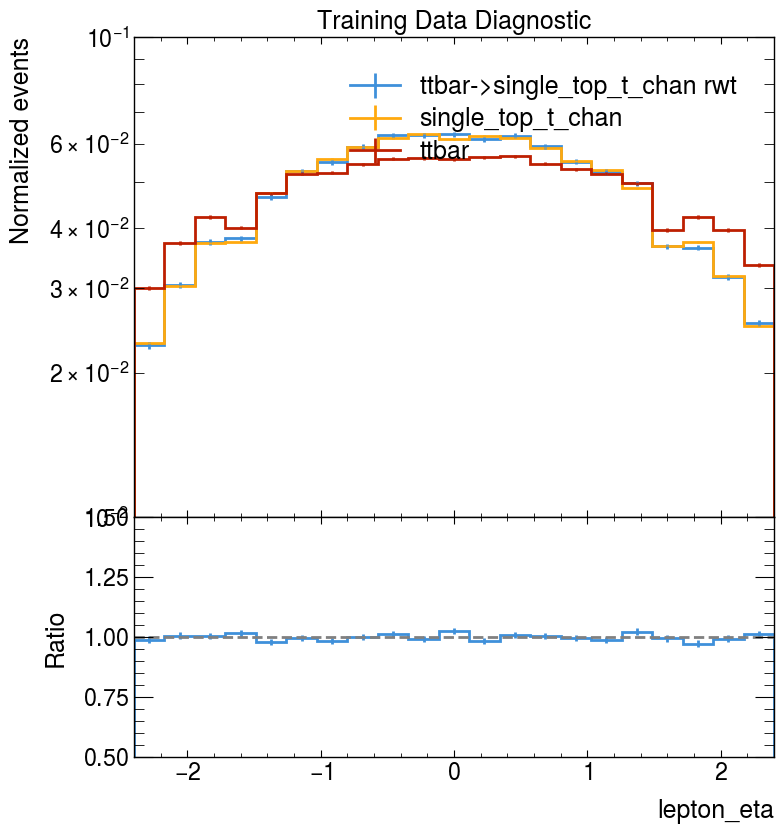

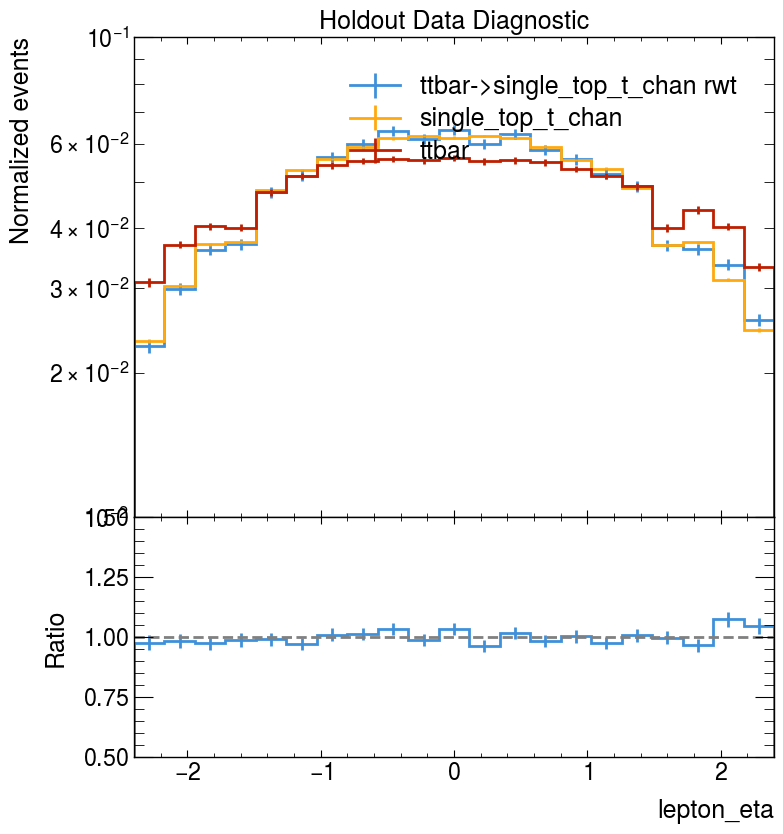

<Figure size 800x600 with 0 Axes>

In [71]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


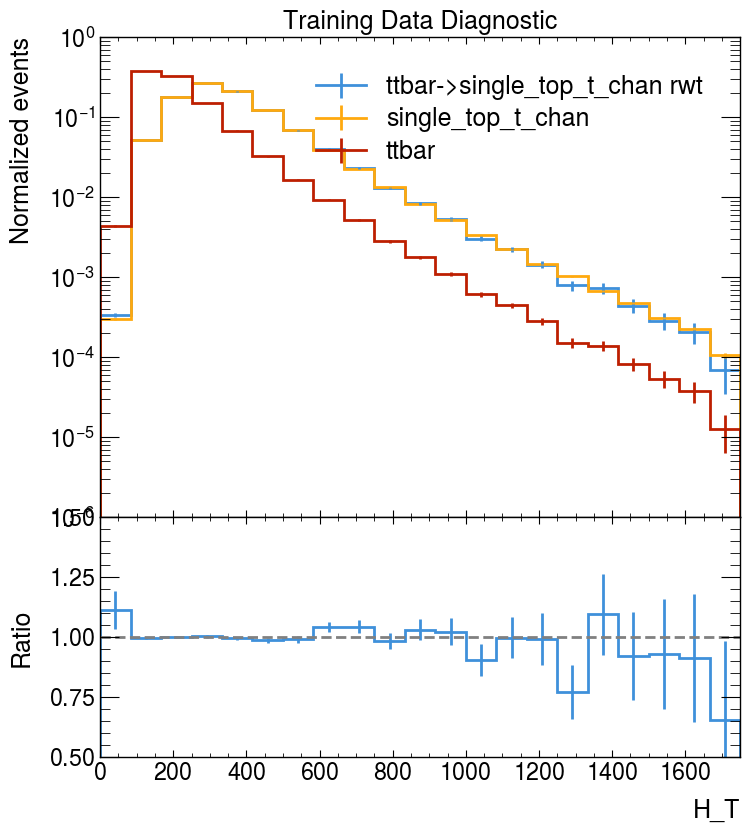

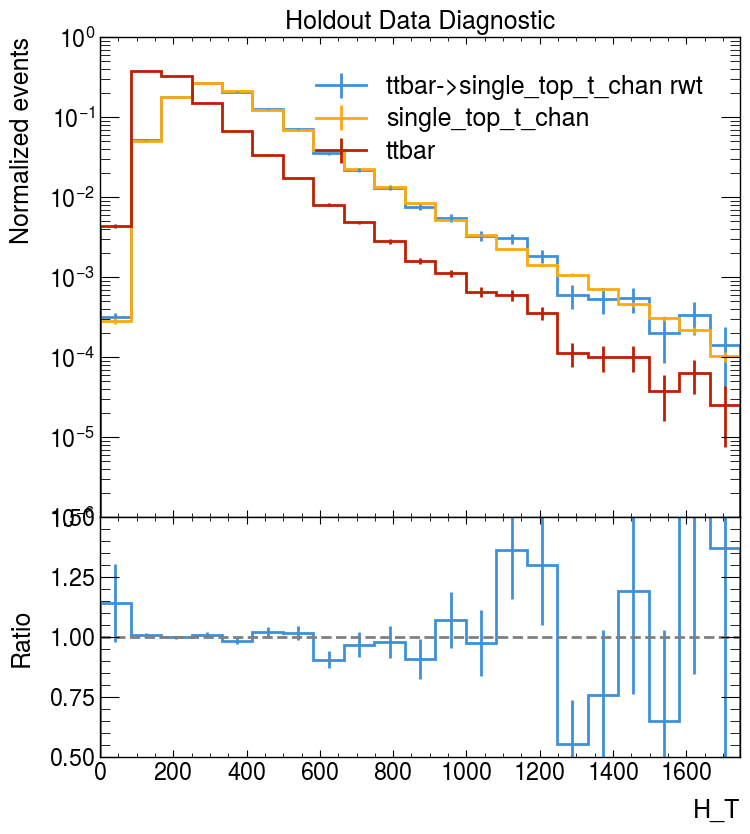

<Figure size 800x600 with 0 Axes>

In [72]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


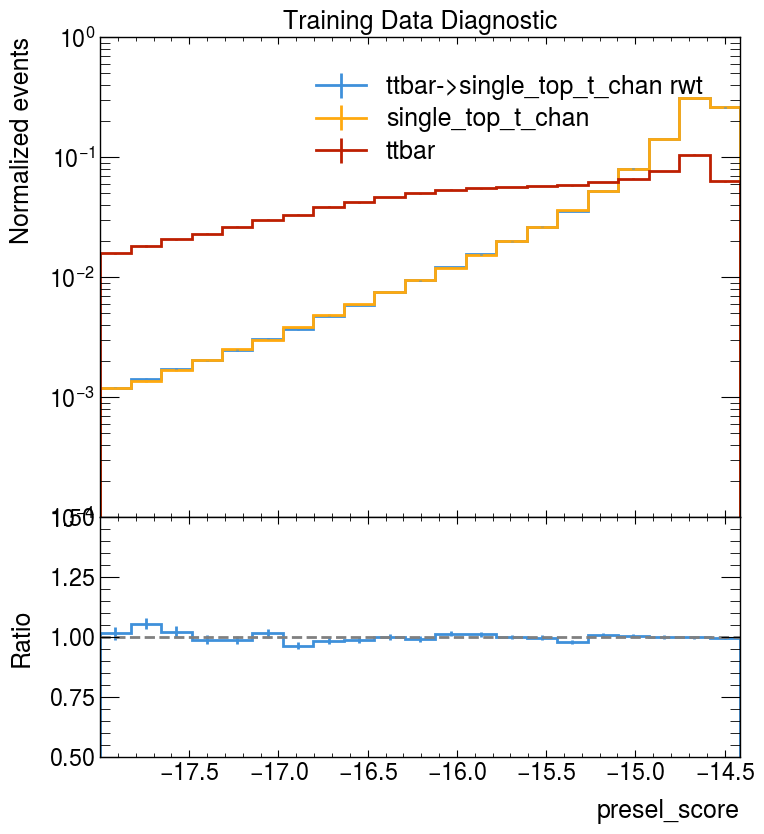

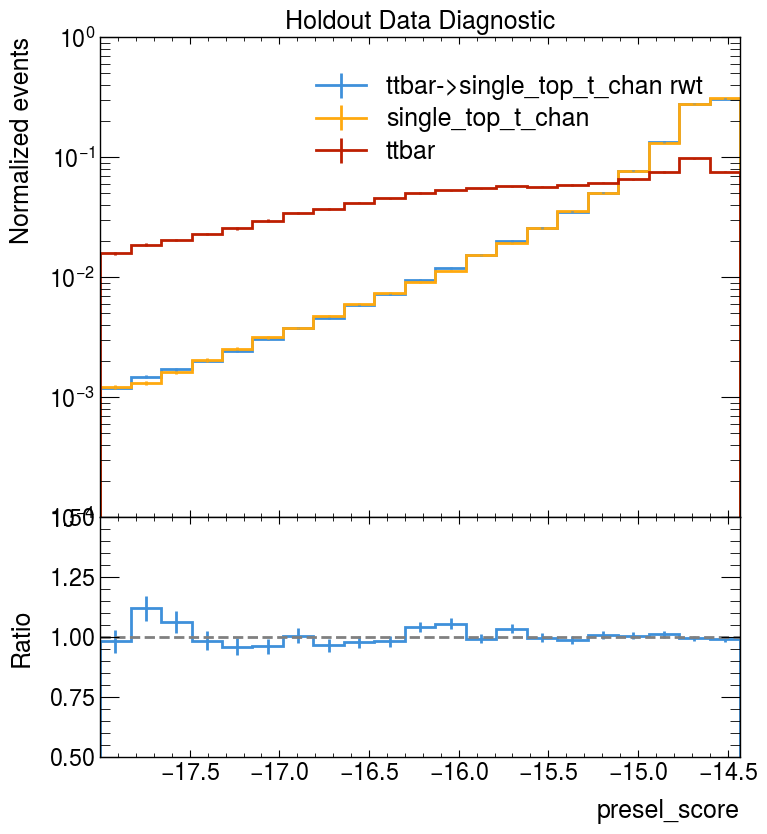

<Figure size 800x600 with 0 Axes>

In [73]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [74]:
NN_training_channels_dict['singletop'].evaluate_and_save_ratios(dataset)


96110/96110 - 57s - 57s/epoch - 595us/step


In [76]:
# backup code for updating class methods 
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN
import types

NN_training_channels_dict['wjets'].make_reweighted_plots = types.MethodType(TrainEvaluate_NN.make_reweighted_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_calib_plots = types.MethodType(TrainEvaluate_NN.make_calib_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].evaluate_and_save_ratios = types.MethodType(TrainEvaluate_NN.evaluate_and_save_ratios, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_overfit_plots = types.MethodType(TrainEvaluate_NN.make_overfit_plots, NN_training_channels_dict['wjets'])
